In [ ]:
%load_ext autoreload
%autoreload 2
#new testing
import glob
from fibsem.segmentation.model import SegmentationModel
import tifffile as tf
import matplotlib.pyplot as plt


from random import shuffle

import numpy as np 
# from autoscript_sdb_microscope_client.structures import AdornedImage

from fibsem.structures import Point
from fibsem.imaging import masks
from fibsem.detection.detection import NeedleTip, LamellaCentre, locate_shift_between_features_v2, plot_det_result_v2
import skimage

from pathlib import Path
from dataclasses import dataclass

from fibsem import conversions


from pprint import pprint


from fibsem.segmentation.model import load_model

## Detection Goals


1. Detect Needle Tip
2. Detect Lamella Centre
3. Detect Lamella Edges (Right / Left, Up / Down)

account for multiple lamellas
mask centre?

In [ ]:
labels = []
p1_type = []
p2_type = []
p1_x = []
p1_y = []
p2_x = []
p2_y = []

In [ ]:


# data

from fibsem import config



# filenames = glob.glob(r"C:\Users\Admin\Github\fibsem\fibsem\segmentation\data\train\images/*.tif")
filenames = glob.glob(r"C:\Users\Rohit\Documents\UNI\DEMARCO\new_eval\label_00\*.tif")
assert len(filenames) > 0
print(len(filenames))

# model
checkpoint = r"C:\Users\Rohit\Documents\UNI\DEMARCO\seg_model_fibsem\model4.pt"
model = load_model(checkpoint,encoder="resnet34")




def to_bounding_box(contour):
    # convert a contour to bounding box (xc, yc, w, h)
    # ref : https://muthu.co/draw-bounding-box-around-contours-skimage/

    xmin, xmax = np.min(contour[:, 1]), np.max(contour[:, 1])
    ymin, ymax = np.min(contour[:, 0]), np.max(contour[:, 0])

    w = (xmax - xmin)
    h = (ymax - ymin)
    xc = xmin + w // 2
    yc = ymin + h // 2
    
    return [xc, yc, w, h]
    
# THINGS TO TRY:
# masking centre area for lamella
# using contours to extract individual lamellas -> pick centre



for i, fname in enumerate(filenames):

    img = tf.imread(fname)

    # inference
    mask = model.inference(img)

    # detect features
    features = [NeedleTip(), LamellaCentre()]

    det = locate_shift_between_features_v2(img, model, features=features, pixelsize=10e-9)
    label = name = fname.split('\\')[-1][:-4]
    labels.append(label)
    # plot
    plot_det_result_v2(det)
    base_file_path = r"C:\Users\rkan0039\Documents\detection_training\evaluation\_{}f"
   
    #plot_det_result_EVAL(det,save=True,save_path=save_path)
    f1 = det.features[0]
    f2 = det.features[1]

    p1_type.append(f1.name)
    p2_type.append(f2.name)
    p1_x.append(f1.px.x)
    p1_y.append(f1.px.y)
    p2_x.append(f2.px.x)
    p2_y.append(f2.px.y)

    print(f"Feature: {f1.name}:  x: {f1.px.x}, y: {f1.px.y}")
    print(f"Feature: {f2.name}:  x: {f2.px.x}, y: {f2.px.y}")

    data = {"label":labels,"p1_type":p1_type,"p1_x":p1_x,"p1_y":p1_y,"p2_type":p2_type,"p2_x":p2_x,"p2_y":p2_y}

    if i == 0:
        break


In [ ]:
import pandas as pd

df = pd.DataFrame(data)

df.to_csv(r"C:\Users\Rohit\Documents\UNI\DEMARCO\new_eval\label_00\ML_output.csv")

In [ ]:
print(p1_x)

In [ ]:


# mask helper


# centre circle
# left/right half
# top/bottom half


from fibsem.imaging import masks
import numpy as np


arr = np.zeros(shape=(720, 1200 ))

circ_mask = masks.create_circle_mask(arr.shape, radius=128)

bl_mask = masks.create_area_mask(arr, left=True, lower=True)
ul_mask = masks.create_area_mask(arr, left=True, upper=True)
br_mask = masks.create_area_mask(arr, left=True, lower=True)
ur_mask = masks.create_area_mask(arr, right=True, upper=True)
mask = masks.create_area_mask(arr, left=True)


fig, ax = plt.subplots(1, 5, figsize=(15, 7))
ax[0].imshow(bl_mask)
ax[1].imshow(ul_mask)
ax[2].imshow(br_mask)
ax[3].imshow(ur_mask)
ax[4].imshow(mask)
plt.show()



In [ ]:
# contour stuff
    # options for getting individual lamella from multiple: contours, masking 
    # bboxes = []
    # contours = skimage.measure.find_contours(lamella_mask[:, :, 0].astype(np.uint8), 0.8)
    # for contour in contours:
    #     bboxes.append(to_bounding_box(contour))
        # for contour in contours:
    #     ax[1].plot(contour[:, 1], contour[:, 0], color="white", linewidth=1)
    

In [ ]:
## vertical mask for eucentric correction

# autoreload 2
%load_ext autoreload
%autoreload 2

from fibsem.imaging import masks
import numpy as np
import matplotlib.pyplot as plt

# mask only the central vertical area
arr = np.zeros(shape=(1024, 1536 ))

mask = masks.create_vertical_mask(arr)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.imshow(mask)
plt.show()



## Refactor Feature Detection Masks

Migrate from RGB masks to Binary masks

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy
from pathlib import Path

import napari
import napari.utils.notifications
import numpy as np
import tifffile as tff
from PyQt5 import QtWidgets

from fibsem.detection import detection
from fibsem.detection import utils as det_utils
from fibsem.detection.detection import DetectedFeatures
from fibsem.segmentation import model as fibsem_model
from fibsem.segmentation.model import load_model
from fibsem.structures import (
    BeamType,
    FibsemImage,
    Point,
)
from PyQt5.QtCore import pyqtSignal
from fibsem.ui.qtdesigner_files import FibsemDetectionWidget
import logging

CHECKPOINT_PATH = os.path.join(os.path.dirname(fibsem_model.__file__), "models", "model4.pt")

In [ ]:
checkpoint = str(CHECKPOINT_PATH)
encoder="resnet34"
num_classes = 3
model = load_model(checkpoint=checkpoint, encoder=encoder, nc=num_classes)

features = [detection.NeedleTip(), detection.LamellaCentre()]

image = FibsemImage.load(os.path.join(os.path.dirname(detection.__file__), "test_image.tif"))


In [ ]:
# detect features
features = [detection.NeedleTip(), detection.LamellaCentre()]
pixelsize = image.metadata.pixel_size.x if image.metadata is not None else 25e-9
det = detection.locate_shift_between_features_v2(
    deepcopy(image.data), model, features=features, pixelsize=pixelsize
)

# plot image and mask overlay
detection.plot_det_result_v2(det)


features = [detection.LamellaLeftEdge(), detection.LandingPost()]
pixelsize = image.metadata.pixel_size.x if image.metadata is not None else 25e-9
det = detection.locate_shift_between_features_v2(
    deepcopy(image.data), model, features=features, pixelsize=pixelsize
)

# plot image and mask overlay
detection.plot_det_result_v2(det)


## N Feature Detection

In [ ]:
# detect features
features = [detection.NeedleTip(), detection.LamellaCentre(), 
            detection.LamellaLeftEdge(), detection.LamellaRightEdge(), 
            detection.LandingPost(), detection.ImageCentre()]
pixelsize = image.metadata.pixel_size.x if image.metadata is not None else 25e-9
det = detection.locate_shift_between_features_v2(
    deepcopy(image.data), model, features=features, pixelsize=pixelsize
)

# plot image and mask overlay
detection.plot_det_result_v2(det)


## Load Log Data


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import glob


import pandas as pd
import numpy as np
import plotly.express as px


path = "/home/patrick/github/fibsem/fibsem/log/data"
df = pd.read_csv(os.path.join(path, "data.csv"))


In [ ]:
# plot p.x, p.y color by feature
fig = px.scatter(df, x="p.x", y="p.y", color="feature")
fig.show()


In [ ]:

from fibsem.detection import detection
import random
# get list of unique images
filenames = df["image"].unique()
random.shuffle(filenames)

i=0

# loop through each image, get all features
for fname in filenames:

    det = detection._det_from_df(df, path, fname)

    if det is None:
        continue

    detection.plot_det_result_v2(det)

    if i==20:
        break

    i+=1



## Multiple Feature Detection

P1: Contour Detection

P2: Instance Segmentation Model



In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy
from pathlib import Path

import napari
import napari.utils.notifications
import numpy as np
import tifffile as tff
from PyQt5 import QtWidgets

from fibsem.detection import detection
from fibsem.detection import utils as det_utils
from fibsem.detection.detection import DetectedFeatures
from fibsem.segmentation import model as fibsem_model
from fibsem.segmentation.model import load_model
from fibsem.structures import (
    BeamType,
    FibsemImage,
    Point,
)
from PyQt5.QtCore import pyqtSignal
from fibsem.ui.qtdesigner_files import FibsemDetectionWidget
import logging

CHECKPOINT_PATH = os.path.join(os.path.dirname(fibsem_model.__file__), "models", "model4.pt")

c:\Users\pcle0002\Miniconda3\envs\fibsem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy
from pathlib import Path

import napari
import napari.utils.notifications
import numpy as np
import tifffile as tff
from PyQt5 import QtWidgets

from fibsem.detection import detection
from fibsem.detection import utils as det_utils
from fibsem.detection.detection import DetectedFeatures
from fibsem.segmentation import model as fibsem_model
from fibsem.segmentation.model import load_model
from fibsem.structures import (
    BeamType,
    FibsemImage,
    Point,
)
from PyQt5.QtCore import pyqtSignal
from fibsem.ui.qtdesigner_files import FibsemDetectionWidget
import logging

from fibsem.detection.detection import Feature, LamellaCentre, LamellaLeftEdge, LamellaRightEdge
import matplotlib.pyplot as plt

CHECKPOINT_PATH = os.path.join(os.path.dirname(fibsem_model.__file__), "models", "model4.pt")

c:\Users\pcle0002\Miniconda3\envs\fibsem\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
checkpoint = str(CHECKPOINT_PATH)
encoder="resnet34"
num_classes = 3
model = load_model(checkpoint=checkpoint, encoder=encoder, nc=num_classes)

features = [detection.NeedleTip(), detection.LamellaCentre()]

image = FibsemImage.load(os.path.join(os.path.dirname(detection.__file__), "test_image.tif"))

Error: resolution must be a list, currently is <class 'tuple'>


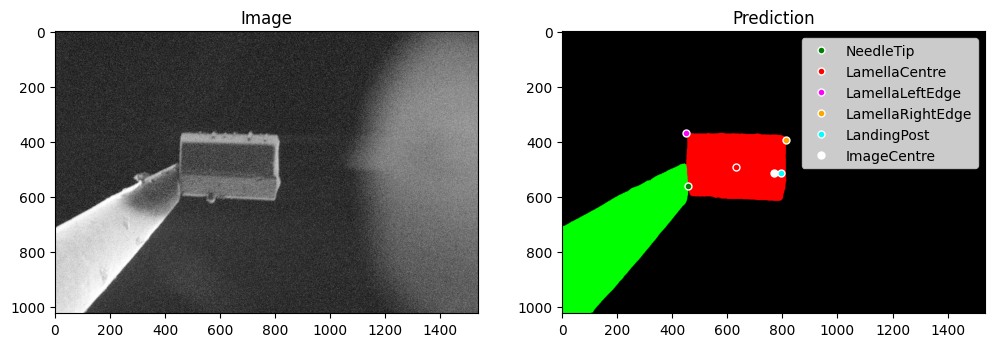

In [15]:
# detect features
features = [detection.NeedleTip(), detection.LamellaCentre(), 
            detection.LamellaLeftEdge(), detection.LamellaRightEdge(), 
            detection.LandingPost(), detection.ImageCentre()]
pixelsize = image.metadata.pixel_size.x if image.metadata is not None else 25e-9
det = detection.locate_shift_between_features_v2(
    deepcopy(image.data), model, features=features, pixelsize=pixelsize
)

# plot image and mask overlay
detection.plot_det_result_v2(det)

In [ ]:
det.distance

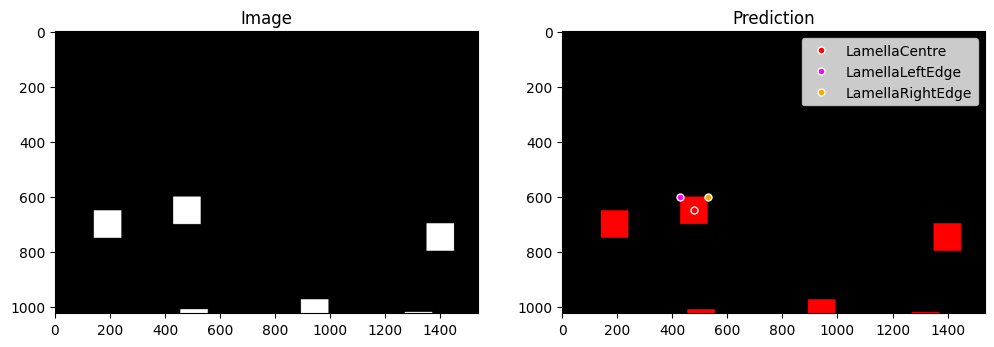

[LamellaCentre(px=Point(x=478, y=650), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre'),
 LamellaLeftEdge(px=Point(x=428, y=600), feature_m=None, _color_UINT8=(255, 0, 255), name='LamellaLeftEdge'),
 LamellaRightEdge(px=Point(x=528, y=600), feature_m=None, _color_UINT8=(255, 165, 0), name='LamellaRightEdge')]


In [24]:


def create_random_image(n: int = 3):
    image = np.zeros(shape=(1024, 1536 ))
    # create two squares at two random non-overlapping locations
    x1 = np.random.randint(0, image.shape[1])
    y1 = np.random.randint(0, image.shape[0])

    x2 = np.random.randint(0, image.shape[1])
    y2 = np.random.randint(0, image.shape[0])

    while (x1-x2)**2 + (y1-y2)**2 < 100**2:
        x2 = np.random.randint(0, image.shape[1])
        y2 = np.random.randint(0, image.shape[0])

    image[y1:y1+100, x1:x1+100] = 1
    image[y2:y2+100, x2:x2+100] = 1

    # convert image to int
    image = image.astype(np.uint8)
    return image

img1 = create_random_image()
img2 = create_random_image()
img3 = create_random_image()
image = img1 + img2 + img3
mask = np.clip(image, image, 1)

# create a random square in the middle of the image
# image = np.zeros(shape=(1024, 1536 ))
# image[512:612, 768:868] = 1
# mask = np.clip(image, image, 1)


# sub this in for lamlla detections
# features = detection.detect_multi_features(image, mask, LamellaCentre())
# best_feature = detection.filter_best_feature(mask, features, method="closest")



# # plot all on same image
# fig, ax = plt.subplots(1, 1, figsize=(15, 7))
# ax.imshow(mask, cmap="gray")

# colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "grey"]
# for i, feature in enumerate(features):
#     ax.plot(feature.px.x, feature.px.y, marker="+", color=colors[i], ms=20, label=f"{feature.name} {i:02d}")

# # ax.plot(best_feature.px.x, 
# #         best_feature.px.y, marker="o", color="red", 
# #         markeredgecolor="w",  
# #         ms=10, 
# #         label=f"BEST: {best_feature.name}")

# ax.legend(loc="best")
# ax.set_title(f"Best feature: {best_feature.name}")
# plt.show()

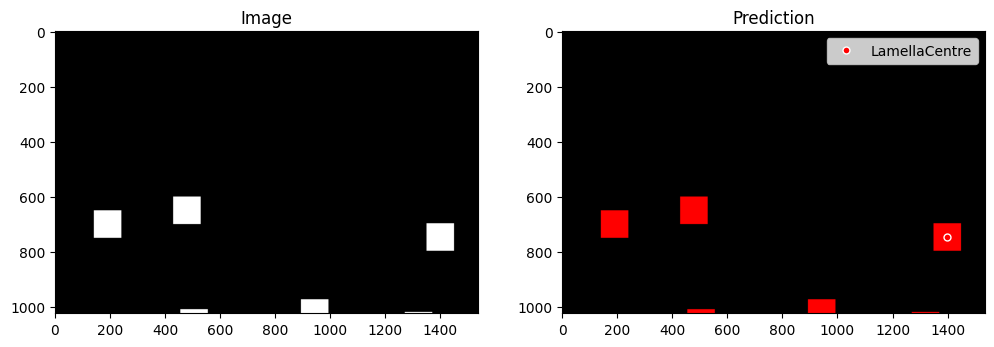

[LamellaCentre(px=Point(x=1398, y=747), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre')]


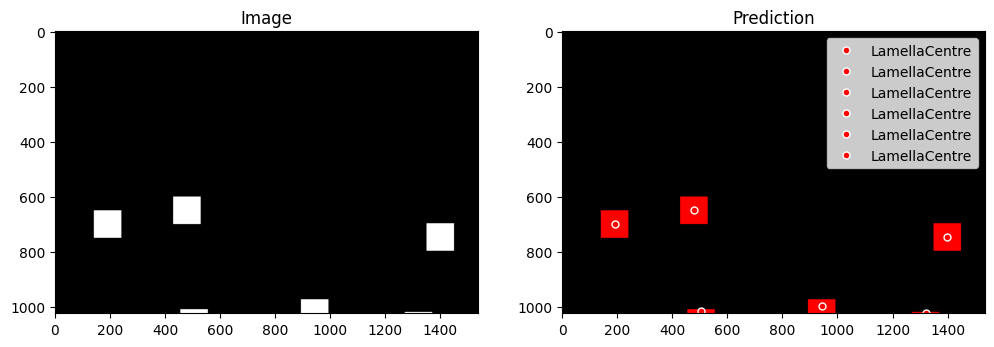

[LamellaCentre(px=Point(x=478, y=650), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre'),
 LamellaCentre(px=Point(x=190, y=700), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre'),
 LamellaCentre(px=Point(x=1398, y=747), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre'),
 LamellaCentre(px=Point(x=942, y=998), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre'),
 LamellaCentre(px=Point(x=504, y=1016), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre'),
 LamellaCentre(px=Point(x=1320, y=1021), feature_m=None, _color_UINT8=(255, 0, 0), name='LamellaCentre')]


In [42]:
features = [
            detection.LamellaCentre(), 
            # detection.LamellaLeftEdge(), 
            # detection.LamellaRightEdge(), 
            ]


point = Point(1400, 800)
features = detection.detect_features_v2(image, mask, features, filter=True, point=point)

det = DetectedFeatures(features, image, mask, det_utils.decode_segmap(mask), pixelsize=25e-9)

detection.plot_det_result_v2(det)

from pprint import pprint 
pprint(features)

features = [
            detection.LamellaCentre(), 
            # detection.LamellaLeftEdge(), 
            # detection.LamellaRightEdge(), 
            ]

features = detection.detect_features_v2(image, mask, features, filter=False)

det = DetectedFeatures(features, image, mask, det_utils.decode_segmap(mask), pixelsize=25e-9)

detection.plot_det_result_v2(det)

from pprint import pprint 
pprint(features)